In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline # Used to smoothen out data
import statsmodels.api as sm # Used later to estimate a team's "quality"
import matplotlib.pyplot as plt

In [3]:
MRegularSeasonCompactResults = pd.read_csv('../../data/MRegularSeasonCompactResults.csv')
WRegularSeasonCompactResults = pd.read_csv('../../data/WRegularSeasonCompactResults.csv')
MRegularSeasonDetailedResults = pd.read_csv('../../data/MRegularSeasonDetailedResults.csv')
WRegularSeasonDetailedResults = pd.read_csv('../../data/WRegularSeasonDetailedResults.csv')
MNCAATourneyCompactResults = pd.read_csv('../../data/MNCAATourneyCompactResults.csv')
WNCAATourneyCompactResults = pd.read_csv('../../data/WNCAATourneyCompactResults.csv')
MNCAATourneyDetailedResults = pd.read_csv('../../data/MNCAATourneyDetailedResults.csv') 
WNCAATourneyDetailedResults = pd.read_csv('../../data/WNCAATourneyDetailedResults.csv')
MNCAATourneySeeds = pd.read_csv('../../data/MNCAATourneySeeds.csv')
WNCAATourneySeeds = pd.read_csv('../../data/WNCAATourneySeeds.csv')
MGameCities = pd.read_csv('../../data/MGameCities.csv') 
WGameCities = pd.read_csv('../../data/WGameCities.csv')
MSeasons = pd.read_csv('../../data/MSeasons.csv') 
WSeasons = pd.read_csv('../../data/WSeasons.csv')

In [4]:
tourney_results = pd.concat([
    MNCAATourneyDetailedResults, WNCAATourneyDetailedResults
], ignore_index=True)

seeds = pd.concat([
    MNCAATourneySeeds, WNCAATourneySeeds
], ignore_index=True)

regular_results = pd.concat([
    MRegularSeasonDetailedResults, WRegularSeasonDetailedResults
], ignore_index=True)

## Making every game appear twice (from both winner and loser's perspective)

#### Also "one-hot encodes" location (1 = home, -1 = away, 0 = neutral)

In [5]:
def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

In [6]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

# Feature selection (IMPROVE FEATURE ENGINEERING)

In [7]:
features = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

# Computing season averages for each feature for each team

#### Also replacing "T2" with "Opponent" and "T1" with an empty string

In [8]:
funcs = [np.mean]

season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[features].agg(funcs).reset_index()

season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]

season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

/var/folders/fg/_cm9z0lx34b9zrpmj_h8s3q80000gn/T/ipykernel_89379/4129688711.py:3: FutureWarning: The provided callable <function mean at 0x103ea8360> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[features].agg(funcs).reset_index()


In [9]:
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]

tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

## Win ratio for every team in the last 14 days of the regular season

In [10]:
last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')


In [11]:
tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [12]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])

# Using a logistic regression model to classify teams based on "quality"

In [13]:
def team_quality(season):
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_season_effects.loc[regular_season_effects.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','quality']
    quality['Season'] = season
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    return quality


In [14]:
formula = 'win~-1+T1_TeamID+T2_TeamID'
glm = sm.GLM.from_formula(formula=formula, 
                          data=regular_season_effects.loc[regular_season_effects.Season==2010,:], 
                          family=sm.families.Binomial()).fit()

quality = pd.DataFrame(glm.params).reset_index()

glm_quality = pd.concat([team_quality(2010),
                         team_quality(2011),
                         team_quality(2012),
                         team_quality(2013),
                         team_quality(2014),
                         team_quality(2015),
                         team_quality(2016),
                         team_quality(2017),
                         team_quality(2018),
                         team_quality(2019),
                         ##team_quality(2020),
                         team_quality(2021),
                         team_quality(2022),
                         team_quality(2023)
                         ]).reset_index(drop=True)

/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: Runti

In [15]:
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']

In [16]:
tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [17]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))

seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]

# 45 features ---> definitely need to feature engineer

In [18]:
features = list(season_statistics_T1.columns[2:999]) + \
    list(season_statistics_T2.columns[2:999]) + \
    list(seeds_T1.columns[2:999]) + \
    list(seeds_T2.columns[2:999]) + \
    list(last14days_stats_T1.columns[2:999]) + \
    list(last14days_stats_T2.columns[2:999]) + \
    ["Seed_diff"] + ["T1_quality","T2_quality"]

print(len(features))
print(features[:10])

45
['T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean', 'T1_ORmean', 'T1_Astmean', 'T1_TOmean', 'T1_Stlmean', 'T1_PFmean', 'T1_opponent_FGMmean']


In [19]:
features = (
    list(season_statistics_T1.columns[2:]) + 
    list(season_statistics_T2.columns[2:]) + 
    list(seeds_T1.columns[2:]) + 
    list(seeds_T2.columns[2:]) + 
    list(last14days_stats_T1.columns[2:]) + 
    list(last14days_stats_T2.columns[2:]) + 
    ["Seed_diff"] + 
    ["T1_quality", "T2_quality"]
)

# What the features look like in the dataset

In [20]:
display(tourney_data[features].head(10))
print("\nfeatures shape:", tourney_data[features].shape)

,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,...,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,Seed_diff,T1_quality,T2_quality
0,24.379310,56.793103,6.482759,18.000000,12.275862,13.034483,16.206897,7.068966,19.103448,27.793103,...,8.000000,2.600000,1.966667,16,16,1.000000,0.833333,0,NaN,NaN
1,30.321429,65.714286,7.035714,20.071429,15.178571,17.642857,14.785714,8.464286,17.750000,26.357143,...,7.103448,3.655172,4.655172,1,16,0.666667,1.000000,-15,NaN,NaN
2,27.206897,56.896552,4.000000,12.586207,13.689655,15.551724,14.000000,5.206897,19.413793,24.793103,...,7.275862,3.172414,8.689655,10,7,0.666667,0.750000,3,NaN,NaN
3,26.620690,52.689655,6.827586,17.931034,10.586207,15.620690,18.241379,7.103448,20.965517,26.344828,...,6.333333,2.575758,14.909091,11,6,1.000000,1.000000,5,NaN,NaN
4,27.344828,58.724138,6.413793,17.034483,11.241379,16.000000,14.172414,6.551724,17.103448,25.379310,...,7.433333,2.833333,4.400000,8,9,0.333333,0.600000,-1,NaN,NaN
5,29.533333,62.200000,6.066667,15.700000,14.766667,15.633333,15.800000,5.933333,18.400000,24.866667,...,5.483871,2.225806,8.774194,5,12,0.600000,0.800000,-7,NaN,NaN
6,27.366667,60.333333,7.333333,20.600000,13.766667,13.833333,14.033333,8.500000,21.266667,25.066667,...,9.033333,3.066667,1.333333,3,14,0.800000,0.833333,-11,NaN,NaN
7,26.064516,55.451613,7.161290,19.064516,11.935484,15.741935,14.548387,6.806452,18.645161,23.903226,...,4.142857,3.035714,5.821429,9,8,0.500000,0.333333,1,NaN,NaN
8,27.100000,55.800000,7.433333,20.166667,9.733333,18.266667,13.166667,7.000000,19.133333,20.333333,...,5.967742,2.548387,6.677419,4,13,0.800000,1.000000,-9,NaN,NaN
9,30.233333,62.300000,4.800000,14.133333,14.300000,16.733333,14.900000,10.133333,16.700000,24.600000,...,5.000000,2.100000,5.866667,2,15,0.750000,1.000000,-13,NaN,NaN



features shape: (4552, 45)


In [21]:
y = tourney_data['T1_Score'] - tourney_data['T2_Score']

X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
dtrain = xgb.DMatrix(X_scaled, label=y)

# Loss function (cauchyobj)

In [23]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

# Model parameters (learning rate, tree size, etc)

In [24]:
param = {} 

param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.02 # learning rate --> adjust accordingly 
param['subsample'] = 0.35 ## proprtion of the training data used in each tree
param['colsample_bytree'] = 0.7 ## proportion of features used in each tree
param['num_parallel_tree'] = 10 ## num of trees
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3
param['silent'] = 0 ## making the logs during training very clear 

# Training the model!

In [25]:
xgb_cv = []
repeat_cv = 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 50,
          verbose_eval = 50
        )
    )

Fold repeater 0
[0]	train-mae:13.57905+0.05929	test-mae:13.58116+0.23764


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:09:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:10.43218+0.04165	test-mae:10.53738+0.20949
[100]	train-mae:9.64619+0.03996	test-mae:9.85099+0.17139
[150]	train-mae:9.36727+0.04129	test-mae:9.66345+0.16924
[200]	train-mae:9.21689+0.04181	test-mae:9.60036+0.16984
[250]	train-mae:9.10233+0.04105	test-mae:9.56645+0.16878
[300]	train-mae:9.00234+0.04168	test-mae:9.54846+0.17002
[350]	train-mae:8.91125+0.04159	test-mae:9.54240+0.16962
[400]	train-mae:8.82502+0.04240	test-mae:9.53489+0.16753
[450]	train-mae:8.74325+0.04310	test-mae:9.52949+0.16872
[500]	train-mae:8.66629+0.04294	test-mae:9.53156+0.16828
[505]	train-mae:8.65850+0.04325	test-mae:9.53156+0.16762
Fold repeater 1
[0]	train-mae:13.57869+0.07691	test-mae:13.58000+0.30797


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:10:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:10.43163+0.04860	test-mae:10.54520+0.21530
[100]	train-mae:9.64374+0.04661	test-mae:9.85335+0.19902
[150]	train-mae:9.36550+0.04723	test-mae:9.66558+0.20750
[200]	train-mae:9.21282+0.04675	test-mae:9.60079+0.21778
[250]	train-mae:9.09712+0.04771	test-mae:9.57359+0.22858
[300]	train-mae:8.99792+0.04872	test-mae:9.56062+0.23533
[350]	train-mae:8.90732+0.04874	test-mae:9.55321+0.24076
[400]	train-mae:8.82137+0.04972	test-mae:9.54980+0.24341
[450]	train-mae:8.74066+0.04965	test-mae:9.54967+0.24846
[483]	train-mae:8.68932+0.04952	test-mae:9.55080+0.25037
Fold repeater 2
[0]	train-mae:13.57980+0.05806	test-mae:13.58183+0.23780


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:10:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:10:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:10.43192+0.03436	test-mae:10.54929+0.11301
[100]	train-mae:9.64750+0.04184	test-mae:9.85881+0.15241
[150]	train-mae:9.37083+0.04613	test-mae:9.66692+0.17911
[200]	train-mae:9.21906+0.05061	test-mae:9.59443+0.19084
[250]	train-mae:9.10456+0.05231	test-mae:9.56014+0.19730
[300]	train-mae:9.00704+0.05419	test-mae:9.54267+0.20274
[350]	train-mae:8.91450+0.05404	test-mae:9.53442+0.20689
[400]	train-mae:8.82751+0.05603	test-mae:9.52677+0.21063
[450]	train-mae:8.74717+0.05692	test-mae:9.52328+0.21343
[500]	train-mae:8.66963+0.05747	test-mae:9.52205+0.21669
[550]	train-mae:8.59438+0.05745	test-mae:9.52069+0.21661
[579]	train-mae:8.55283+0.05784	test-mae:9.52288+0.21649
Fold repeater 3
[0]	train-mae:13.57939+0.09822	test-mae:13.58316+0.40185


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:11:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:10.42930+0.03952	test-mae:10.54077+0.15703
[100]	train-mae:9.64527+0.05159	test-mae:9.86117+0.17614
[150]	train-mae:9.36888+0.05461	test-mae:9.66927+0.20644
[200]	train-mae:9.21532+0.05227	test-mae:9.60583+0.21076
[250]	train-mae:9.10036+0.05220	test-mae:9.57875+0.21336
[300]	train-mae:9.00021+0.05206	test-mae:9.56616+0.21656
[350]	train-mae:8.90888+0.05121	test-mae:9.56040+0.21612
[390]	train-mae:8.84052+0.05156	test-mae:9.56005+0.21996
Fold repeater 4
[0]	train-mae:13.57973+0.06841	test-mae:13.58234+0.27625


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:11:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:10.43318+0.03448	test-mae:10.54516+0.20254
[100]	train-mae:9.64909+0.02013	test-mae:9.86014+0.11271
[150]	train-mae:9.37040+0.01571	test-mae:9.67409+0.07902
[200]	train-mae:9.21688+0.01437	test-mae:9.60974+0.06533
[250]	train-mae:9.10121+0.01370	test-mae:9.57980+0.05454
[300]	train-mae:9.00102+0.01557	test-mae:9.56444+0.05339
[350]	train-mae:8.90795+0.01754	test-mae:9.55801+0.05368
[400]	train-mae:8.82229+0.02158	test-mae:9.55356+0.05437
[450]	train-mae:8.74087+0.02508	test-mae:9.55366+0.05840
[469]	train-mae:8.71131+0.02572	test-mae:9.55355+0.06051
Fold repeater 5
[0]	train-mae:13.57898+0.12389	test-mae:13.58077+0.50414


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:11:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:10.43599+0.04555	test-mae:10.54636+0.28830
[100]	train-mae:9.64981+0.04219	test-mae:9.85472+0.19419
[150]	train-mae:9.37340+0.04470	test-mae:9.66589+0.17995
[200]	train-mae:9.22294+0.04602	test-mae:9.59820+0.18632
[250]	train-mae:9.10684+0.04713	test-mae:9.56932+0.19203
[300]	train-mae:9.00870+0.04696	test-mae:9.55247+0.19741
[350]	train-mae:8.91722+0.04825	test-mae:9.53967+0.20250
[400]	train-mae:8.82973+0.04764	test-mae:9.53609+0.20696
[450]	train-mae:8.74840+0.04684	test-mae:9.53002+0.21036
[500]	train-mae:8.67151+0.04797	test-mae:9.52804+0.21226
[550]	train-mae:8.59752+0.04677	test-mae:9.52766+0.21464
[571]	train-mae:8.56696+0.04661	test-mae:9.52749+0.21453
Fold repeater 6
[0]	train-mae:13.57937+0.07331	test-mae:13.58173+0.29783


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:12:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:10.43138+0.02945	test-mae:10.53268+0.18133
[100]	train-mae:9.64906+0.02605	test-mae:9.84955+0.12850
[150]	train-mae:9.37176+0.02750	test-mae:9.66180+0.12390
[200]	train-mae:9.21712+0.02989	test-mae:9.60206+0.12304
[250]	train-mae:9.10024+0.03067	test-mae:9.57880+0.12714
[300]	train-mae:8.99844+0.03130	test-mae:9.56714+0.13286
[350]	train-mae:8.90662+0.03212	test-mae:9.55925+0.13720
[400]	train-mae:8.82160+0.03302	test-mae:9.55658+0.14273
[450]	train-mae:8.74043+0.03288	test-mae:9.55318+0.14609
[500]	train-mae:8.66458+0.03391	test-mae:9.55433+0.14875
[524]	train-mae:8.62919+0.03463	test-mae:9.55324+0.15018
Fold repeater 7
[0]	train-mae:13.57906+0.07200	test-mae:13.58108+0.28985


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:12:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:10.43186+0.05985	test-mae:10.55113+0.26638
[100]	train-mae:9.64525+0.06358	test-mae:9.86577+0.27428
[150]	train-mae:9.36714+0.06505	test-mae:9.68051+0.27216
[200]	train-mae:9.21602+0.06628	test-mae:9.61542+0.27411
[250]	train-mae:9.10082+0.06532	test-mae:9.58970+0.26946
[300]	train-mae:9.00008+0.06403	test-mae:9.57593+0.26527
[350]	train-mae:8.90738+0.06134	test-mae:9.56833+0.26389
[400]	train-mae:8.82143+0.06119	test-mae:9.56478+0.26199
[448]	train-mae:8.74347+0.06138	test-mae:9.56506+0.25928
Fold repeater 8
[0]	train-mae:13.57960+0.10157	test-mae:13.58090+0.41010


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:13:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:13:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:10.43344+0.08019	test-mae:10.53037+0.37989
[100]	train-mae:9.64798+0.08349	test-mae:9.83773+0.36510
[150]	train-mae:9.36815+0.08758	test-mae:9.65904+0.35848
[200]	train-mae:9.21446+0.08943	test-mae:9.60089+0.35352
[250]	train-mae:9.09772+0.09025	test-mae:9.58015+0.35263
[300]	train-mae:8.99787+0.09215	test-mae:9.57010+0.35185
[350]	train-mae:8.90713+0.09266	test-mae:9.56647+0.35205
[400]	train-mae:8.82143+0.09173	test-mae:9.56498+0.35209
[450]	train-mae:8.73970+0.09175	test-mae:9.56904+0.35255
[456]	train-mae:8.73015+0.09131	test-mae:9.56912+0.35225
Fold repeater 9
[0]	train-mae:13.57976+0.06394	test-mae:13.58169+0.25224


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:13:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:10.43332+0.05184	test-mae:10.52869+0.21592
[100]	train-mae:9.65031+0.04693	test-mae:9.84204+0.19604
[150]	train-mae:9.37400+0.04424	test-mae:9.65284+0.19163
[200]	train-mae:9.22026+0.04181	test-mae:9.58994+0.18241
[250]	train-mae:9.10572+0.04106	test-mae:9.56084+0.17705
[300]	train-mae:9.00607+0.04080	test-mae:9.54829+0.17648
[350]	train-mae:8.91397+0.04026	test-mae:9.54059+0.17533
[400]	train-mae:8.82805+0.03906	test-mae:9.54030+0.17520
[414]	train-mae:8.80485+0.03805	test-mae:9.54042+0.17543


# Cross-fold visualizer

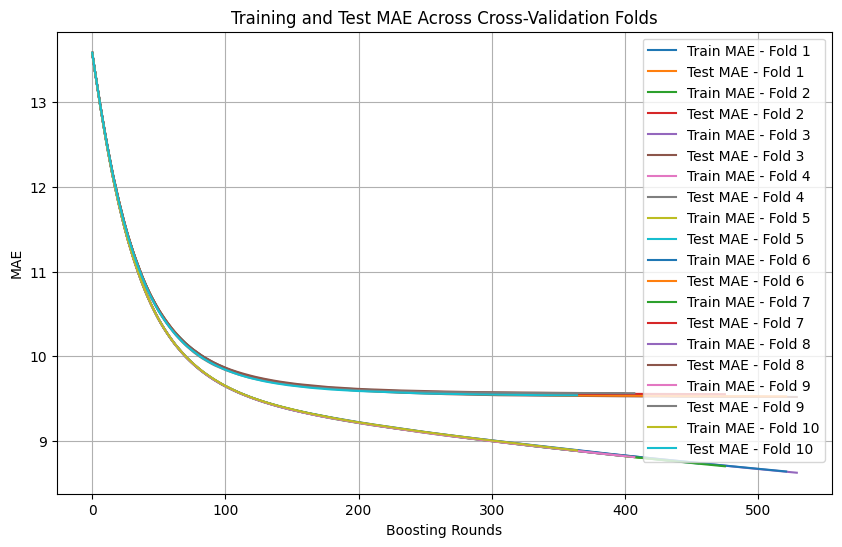

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for i in range(repeat_cv):
    # Plot train and test MAE for the current fold
    plt.plot(xgb_cv[i]['train-mae-mean'], label=f'Train MAE - Fold {i+1}')
    plt.plot(xgb_cv[i]['test-mae-mean'], label=f'Test MAE - Fold {i+1}')

plt.title("Training and Test MAE Across Cross-Validation Folds")
plt.xlabel("Boosting Rounds")
plt.ylabel("MAE")
plt.legend(loc="best")
plt.grid(True)
plt.show()


# Most important features (definitely need to feature engineer)

/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:13:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 1000x800 with 0 Axes>

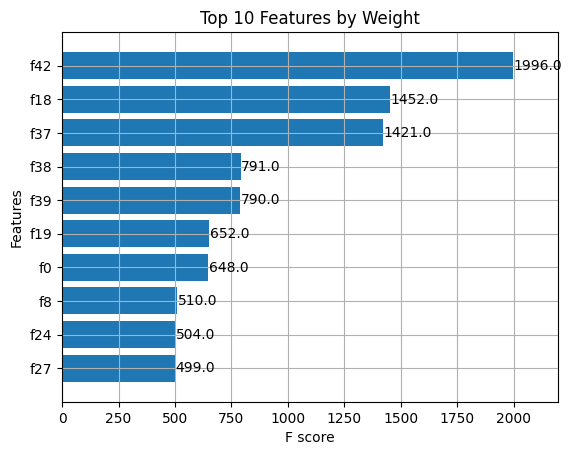

In [27]:
best_num_boost_round = xgb_cv[9].shape[0] 

model = xgb.train(param, dtrain, num_boost_round=best_num_boost_round)

# Plot feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(model, importance_type='weight', max_num_features=10, height=0.8)
plt.title("Top 10 Features by Weight")
plt.show()


In [28]:
print("In order, the most important features are: ")
print(f"1. {features[42]}")
print(f"2. {features[18]}")
print(f"3. {features[37]}")
print(f"4. {features[38]}")
print(f"5. {features[39]}")
print(f"6. {features[19]}")
print(f"7. {features[0]}")
print(f"8. {features[8]}")
print(f"9. {features[24]}")
print(f"10. {features[27]}")

In order, the most important features are: 
1. Seed_diff
2. T1_PointDiffmean
3. T2_PointDiffmean
4. T1_seed
5. T2_seed
6. T2_FGMmean
7. T1_FGMmean
8. T1_PFmean
9. T2_Astmean
10. T2_PFmean


# Learning curve

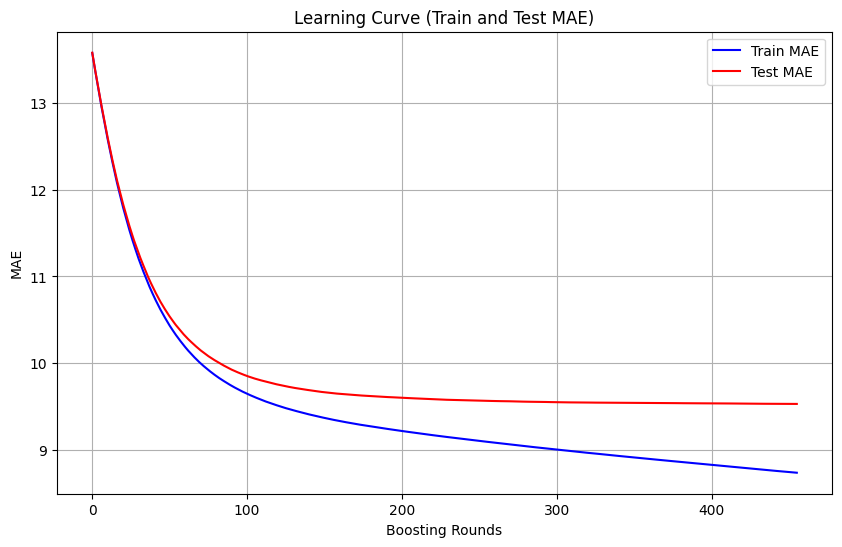

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(xgb_cv[0]['train-mae-mean'], label='Train MAE', color='blue')
plt.plot(xgb_cv[0]['test-mae-mean'], label='Test MAE', color='red')
plt.title("Learning Curve (Train and Test MAE)")
plt.xlabel("Boosting Rounds")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.show()

In [30]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]

oof_preds = []
for i in range(repeat_cv):
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:13:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/var/folders/fg/_cm9z0lx34b9zrpmj_h8s3q80000gn/T/ipykernel_89379/2329130935.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.24787045e+01  1.27093449e+01  5.71084404e+00  2.13864574e+01
  1.04331951e+01 -1.08901930e+00  9.93930054e+00 -8.76553440e+00
 -4.02847099e+00 -9.93473649e-01 -3.22964716e+00 -1.23379445e+00
  5.49173737e+00  3.35820937e+00  1.82695217e+01  4.23195744e+00
  2.70952296e+00  3.10696870e-01 -1.52014530e+00  7.97542095e+00
  2.00649834e+01 -8.10367465e-01  3.36174536e+00  3.05610447e+01
  9.47932625e+00 -2.43512225e+00  1.79141331e+01  6.77442169e+00
  1.13854313e+01  3.59834218e+00  1.34991436e+01 -1.16575062e+00
  4.685366

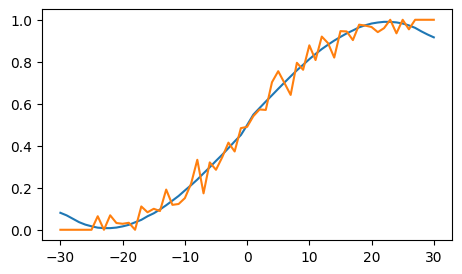

In [31]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))


plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int').mean().reset_index()

plt.figure(figsize=[5.3,3.0])
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

In [32]:
sub = pd.read_csv("../../data/SampleSubmissionStage1.csv")
sub['Season'] = sub['ID'].apply(lambda x: int(x.split('_')[0]))
sub["T1_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[1]))
sub["T2_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[2]))

sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sub = pd.merge(sub, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sub = pd.merge(sub, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]

Xsub = sub[features].values
dtest = xgb.DMatrix(Xsub)


sub_models = []
for i in range(repeat_cv):
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
    
sub["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)
# sub[['ID','Pred']].to_csv("../../submissionImproved.11.2025.csv", index = None)
sub.to_csv("../../full_col_submission.11.2025.csv", index = None)

display(sub[['ID','Pred']].sample(30))

/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:16:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:16:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:16:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:17:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  w

,ID,Pred
229997,2022_3283_3288,0.059932
317490,2023_3117_3151,0.077604
155355,2022_1229_1277,0.077308
348923,2023_3231_3457,0.382984
359066,2023_3279_3347,0.261887
307350,2023_1376_1411,0.102836
454715,2024_3141_3408,0.075575
137749,2022_1162_1396,0.044250
422240,2024_1269_1325,0.025000
130331,2022_1138_1172,0.025000


In [33]:
sub.sample(30)

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,...,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_quality,T2_quality,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,Seed_diff
23063,2021_1186_1355,0.025000,2021,1186,1355,27.636364,58.863636,8.363636,23.318182,6.545455,...,6.409091,3.000000,5.318182,-1.328707e+16,NaN,14.0,NaN,0.800000,0.500000,NaN
65513,2021_3119_3230,0.083030,2021,3119,3230,20.400000,52.900000,6.800000,21.250000,8.850000,...,8.000000,2.500000,-8.285714,NaN,NaN,NaN,NaN,0.000000,0.250000,NaN
58771,2021_1417_1434,0.234491,2021,1417,1434,26.384615,57.115385,6.653846,18.115385,8.769231,...,5.730769,2.461538,-5.346154,-5.251418e+15,NaN,11.0,NaN,0.000000,0.000000,NaN
184710,2022_3105_3132,0.025000,2022,3105,3132,21.758621,57.620690,3.172414,12.379310,10.965517,...,7.655172,3.655172,1.965517,NaN,NaN,NaN,NaN,0.666667,0.333333,NaN
295613,2023_1288_1392,0.084184,2023,1288,1392,25.370370,59.888889,6.481481,17.851852,9.851852,...,7.354839,2.225806,-8.322581,NaN,NaN,NaN,NaN,0.333333,0.500000,NaN
437064,2024_1370_1408,0.105532,2024,1370,1408,25.375000,57.531250,7.531250,21.937500,8.437500,...,6.800000,3.566667,0.966667,NaN,NaN,NaN,NaN,0.250000,0.333333,NaN
489256,2024_3280_3389,0.264352,2024,3280,3389,28.093750,62.437500,6.156250,17.406250,11.343750,...,10.766667,3.166667,-11.866667,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
374409,2023_3399_3438,0.025000,2023,3399,3438,24.689655,57.517241,6.206897,19.206897,9.827586,...,6.833333,4.466667,5.466667,3.040422e+15,NaN,16.0,NaN,1.000000,0.000000,NaN
359583,2023_3282_3298,0.074434,2023,3282,3298,23.200000,59.600000,4.133333,13.333333,11.000000,...,8.833333,2.800000,-16.766667,NaN,NaN,NaN,NaN,0.666667,0.000000,NaN
144654,2022_1186_1352,0.110293,2022,1186,1352,26.000000,57.612903,8.806452,24.483871,7.354839,...,7.225806,3.516129,-7.032258,NaN,NaN,NaN,NaN,0.750000,0.500000,NaN


In [34]:
teams = pd.read_csv('../../data/MTeams.csv')  
MTeam_spellings = pd.read_csv('../../data/MTeamspellings.csv', encoding='ISO-8859-1')  
WTeam_spellings = pd.read_csv('../../data/WTeamspellings.csv', encoding='ISO-8859-1')  
teams_spelling = pd.concat([MTeam_spellings, WTeam_spellings])
teams_spelling = teams_spelling.groupby(by='TeamID', as_index=False)['TeamNameSpelling'].count()
teams_spelling.columns = ['TeamID', 'TeamNameCount']
teams = pd.merge(teams, teams_spelling, how='left', on=['TeamID'])
teams.head()

,TeamID,TeamName,FirstD1Season,LastD1Season,TeamNameCount
0,1101,Abilene Chr,2014,2025,3
1,1102,Air Force,1985,2025,2
2,1103,Akron,1985,2025,1
3,1104,Alabama,1985,2025,1
4,1105,Alabama A&M,2000,2025,2


In [35]:
merged_df = sub.merge(teams, left_on="T1_TeamID", right_on="TeamID", how="left")
merged_df = merged_df.rename(columns={"TeamName": "Team1_Name"}).drop(columns=["TeamID"])


merged_df = merged_df.merge(teams, left_on="T2_TeamID", right_on="TeamID", how="left")
merged_df = merged_df.rename(columns={"TeamName": "Team2_Name"}).drop(columns=["TeamID"])

merged_df.sample(20)


,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,...,T2_win_ratio_14d,Seed_diff,Team1_Name,FirstD1Season_x,LastD1Season_x,TeamNameCount_x,Team2_Name,FirstD1Season_y,LastD1Season_y,TeamNameCount_y
106613,2021_3301_3429,0.379291,2021,3301,3429,29.045455,62.272727,7.045455,19.681818,9.227273,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
316425,2023_3114_3120,0.118625,2023,3114,3120,20.322581,53.000000,0.612903,4.354839,8.709677,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157032,2022_1236_1333,0.174822,2022,1236,1333,25.633333,56.666667,9.166667,25.100000,5.833333,...,0.000000,NaN,PFW,2003.0,2025.0,9.0,Oregon St,1985.0,2025.0,5.0
142254,2022_1178_1200,0.082939,2022,1178,1200,24.535714,56.428571,10.250000,27.857143,8.250000,...,0.600000,NaN,Detroit,1985.0,2025.0,3.0,Fordham,1985.0,2025.0,1.0
138324,2022_1164_1370,0.064181,2022,1164,1370,22.343750,57.843750,8.562500,28.875000,6.781250,...,0.500000,NaN,Coppin St,1986.0,2025.0,5.0,Seattle,2009.0,2025.0,3.0
13203,2021_1149_1300,0.076838,2021,1149,1300,22.250000,55.950000,7.550000,24.300000,7.600000,...,0.333333,NaN,Charleston So,1985.0,2025.0,5.0,NC Central,2008.0,2025.0,5.0
314676,2023_3108_3122,0.025000,2023,3108,3122,22.148148,60.481481,4.592593,16.481481,11.000000,...,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201636,2022_3164_3187,0.030513,2022,3164,3187,21.428571,59.428571,5.357143,20.357143,9.178571,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
489293,2024_3280_3426,0.272073,2024,3280,3426,28.093750,62.437500,6.156250,17.406250,11.343750,...,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
207178,2022_3183_3239,0.117397,2022,3183,3239,24.428571,59.500000,5.571429,17.571429,9.214286,...,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
limited = merged_df[['T1_TeamID', 'T2_TeamID', 'Team1_Name', "Team2_Name", "Pred"]]

In [37]:
limited_notNull = limited.dropna()

In [38]:
high = limited_notNull[limited_notNull['Pred'] > 0.85]
low = limited_notNull[limited_notNull['Pred'] < 0.15]

In [39]:
high.sample(30)

,T1_TeamID,T2_TeamID,Team1_Name,Team2_Name,Pred
122937,1112,1159,Arizona,Colgate,0.975000
25789,1196,1417,Florida,UCLA,0.975000
393492,1155,1305,Clemson,Nevada,0.975000
416164,1241,1253,James Madison,Long Beach St,0.974998
31814,1222,1457,Houston,Winthrop,0.975000
384261,1124,1212,Baylor,Grambling,0.935019
247832,1104,1401,Alabama,Texas A&M,0.975000
380775,1112,1181,Arizona,Duke,0.975000
163383,1266,1276,Marquette,Michigan,0.975000
31798,1222,1439,Houston,Virginia Tech,0.975000


In [40]:
low.sample(20)

,T1_TeamID,T2_TeamID,Team1_Name,Team2_Name,Pred
43240,1278,1326,Minnesota,Ohio St,0.061507
383972,1123,1266,Ball St,Marquette,0.046614
160583,1252,1356,Lipscomb,S Illinois,0.025000
249131,1108,1270,Alcorn St,McNeese St,0.080405
152563,1217,1387,Harvard,St Louis,0.039825
172067,1317,1439,North Texas,Virginia Tech,0.025000
273869,1192,1403,F Dickinson,Texas Tech,0.050556
421724,1266,1418,Marquette,Louisiana,0.041398
269771,1178,1270,Detroit,McNeese St,0.130928
408686,1208,1342,Georgia,Presbyterian,0.107203


In [41]:
limited_notNull["Outcome"] = (limited_notNull["Pred"] >= 0.5).astype(int)

/var/folders/fg/_cm9z0lx34b9zrpmj_h8s3q80000gn/T/ipykernel_89379/3564265647.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limited_notNull["Outcome"] = (limited_notNull["Pred"] >= 0.5).astype(int)


In [42]:
limited_notNull.sample(50)

,T1_TeamID,T2_TeamID,Team1_Name,Team2_Name,Pred,Outcome
292880,1274,1295,Miami FL,N Dakota St,0.229609,0
177719,1363,1375,San Jose St,South Alabama,0.059696,0
269629,1177,1423,DePaul,UNC Wilmington,0.025000,0
127666,1129,1133,Boise St,Bradley,0.025000,0
420348,1260,1276,Loyola-Chicago,Michigan,0.251140,0
302684,1335,1448,Penn,Wake Forest,0.025000,0
271172,1183,1231,E Illinois,Indiana,0.077642,0
172052,1317,1423,North Texas,UNC Wilmington,0.081404,0
253987,1125,1261,Belmont,LSU,0.266139,0
147612,1197,1317,Florida A&M,North Texas,0.058687,0


In [43]:
limited_notNull['Outcome'].value_counts()

Outcome
0    250094
1      4884
Name: count, dtype: int64